# QSAR

In [2]:
DATASET_NAME = 'DIAZEPAM.sdf'
ACTIVITY_COLUMN = 'Bio_Activity'

In [3]:
import cheminf as cinf  
import os

mols = cinf.read_sdfile_from_data(DATASET_NAME)




[<rdkit.Chem.rdchem.Mol object at 0x7ffc96979e40>, <rdkit.Chem.rdchem.Mol object at 0x7ffc96979e90>, <rdkit.Chem.rdchem.Mol object at 0x7ffc96979ee0>, <rdkit.Chem.rdchem.Mol object at 0x7ffc96979f30>, <rdkit.Chem.rdchem.Mol object at 0x7ffc96979f80>, <rdkit.Chem.rdchem.Mol object at 0x7ffc9697e030>, <rdkit.Chem.rdchem.Mol object at 0x7ffc9697e080>, <rdkit.Chem.rdchem.Mol object at 0x7ffc9697e0d0>, <rdkit.Chem.rdchem.Mol object at 0x7ffc9697e120>, <rdkit.Chem.rdchem.Mol object at 0x7ffc9697e170>, <rdkit.Chem.rdchem.Mol object at 0x7ffc9697e1c0>, <rdkit.Chem.rdchem.Mol object at 0x7ffc9697e210>, <rdkit.Chem.rdchem.Mol object at 0x7ffc9697e260>, <rdkit.Chem.rdchem.Mol object at 0x7ffc9697e2b0>, <rdkit.Chem.rdchem.Mol object at 0x7ffc9697e300>, <rdkit.Chem.rdchem.Mol object at 0x7ffc9697e350>, <rdkit.Chem.rdchem.Mol object at 0x7ffc9697e3a0>, <rdkit.Chem.rdchem.Mol object at 0x7ffc9697e3f0>, <rdkit.Chem.rdchem.Mol object at 0x7ffc9697e440>, <rdkit.Chem.rdchem.Mol object at 0x7ffc9697e490>,

In [5]:
from rdkit import Chem 
from rdkit.Chem import PandasTools
import pandas as pd

In [31]:
df = pd.read_csv('data/solubility.txt', sep='\t')
df['ROMol'] = [Chem.MolFromSmiles(smi) for smi in df.SMILES]

In [9]:
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors

def calc_descriptors_from_mol(mol):
    """
    Encode a molecule from a RDKit Mol into a set of descriptors.

    Parameters
    ----------
    mol : RDKit Mol
        The RDKit molecule.

    Returns
    -------
    list
        The set of chemical descriptors as a list.

    """
    calc = MoleculeDescriptors.MolecularDescriptorCalculator([desc[0] for desc in Descriptors.descList])
    return list(calc.CalcDescriptors(mol))

In [32]:
desc_list = []


for mol in df.ROMol.tolist():
    desc = calc_descriptors_from_mol(mol)
    desc_list.append(desc)

    
desc_frame = pd.DataFrame(desc_list)

In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

desc_frame_std = pd.DataFrame(scaler.fit_transform(desc_frame))

desc_frame_std.head()

,0,1,2,3,4,5,6,7,8,9,...,198,199,200,201,202,203,204,205,206,207
0,-0.848527,-0.824512,-0.848527,-0.913644,-0.446074,-0.358581,-0.265772,-0.374236,-0.950569,0.0,...,-0.175016,-0.129182,-0.059235,-0.115265,0.0,-0.078464,0.0,-0.041849,-0.212634,-0.26992
1,-0.863558,-0.677348,-0.863558,1.225446,-0.727091,-0.694382,-0.623142,-0.706413,-1.117050,0.0,...,-0.175016,-0.129182,-0.059235,-0.115265,0.0,-0.078464,0.0,-0.041849,-0.212634,-0.26992
2,-0.849153,-0.364181,-0.849153,0.384355,-0.177065,-0.358581,-0.265772,-0.374236,-0.950569,0.0,...,-0.175016,-0.129182,-0.059235,-0.115265,0.0,-0.078464,0.0,-0.041849,-0.212634,-0.26992
3,-0.854164,-0.160506,-0.854164,-0.361876,-0.492145,-0.694382,-0.623142,-0.706413,-1.117050,0.0,...,-0.175016,-0.129182,-0.059235,-0.115265,0.0,-0.078464,0.0,-0.041849,-0.212634,-0.26992
4,0.890706,-3.074953,0.890706,6.558152,0.000011,-0.168234,-0.048636,-0.178508,-0.617608,0.0,...,-0.175016,-0.129182,-0.059235,-0.115265,0.0,-0.078464,0.0,-0.041849,-0.212634,-0.26992


In [35]:
X = desc_frame_std.copy()
y = df['measured log(solubility:mol/L)'].astype(float)

print(X.shape)
print(y.shape)

(1144, 208)
(1144,)


<AxesSubplot:>

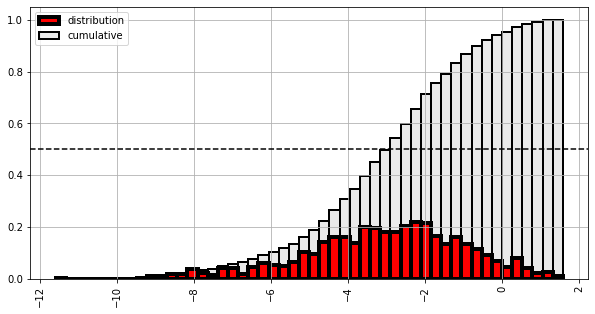

In [39]:
bins = 50

ax = y.hist(bins=bins, edgecolor='k', lw=4, facecolor=(1, 0, 0, 1), figsize=(10,5), xrot=90, density=True, label='distribution')
y.hist(cumulative=True, density=1, bins=bins, label='cumulative', zorder=0, facecolor=(0.8, 0.8, 0.8, 0.4), edgecolor='k', lw=2, figsize=(10,5))
ax.axhline(0.5, ls='--', c='k')
ax.legend()
ax

In [40]:
X_train, y_train = X.copy(), y.copy()

In [46]:
X.shape

(1144, 208)

In [41]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# ANN
model_ANN = MLPRegressor(hidden_layer_sizes=(5, 3), random_state=0)

# SVM
model_SVM = SVR()

# RF
model_RF = RandomForestRegressor(n_estimators=100)

#knn
model_KNN = KNeighborsRegressor(n_neighbors=3, metric='jaccard')


models = {
    "rf": model_RF,
    "svm": model_SVM,
    "ann": model_ANN,
    "knn": model_KNN
}

In [42]:
from sklearn import model_selection
from sklearn import pipeline
from sklearn.model_selection import cross_val_predict

In [43]:
params_dic = {
    'svm' : {'svm__kernel': ['rbf'], 'svm__gamma': [1e-2, 1e-3], 'svm__C': [1, 10]}
}



In [44]:
N_FOLDS = 5

name = 'svm'
clf = models[name]
params = params_dic[name]
pipe = pipeline.Pipeline([(name, clf)])
cv = KFold(n_splits=N_FOLDS, shuffle=True, random_state=0)
grid_search = model_selection.GridSearchCV(pipe, param_grid=params, cv=cv, refit='AUC')
grid_search.fit(X_train, y_train)
best_estimator = grid_search.best_estimator_


In [49]:
preds = cross_val_predict(best_estimator, X, y)
preds

array([-2.33811196, -2.06111117, -2.29611181, ..., -4.64267494,
       -3.90004599, -2.16840453])

In [54]:
preds_df = pd.DataFrame(y.copy())


In [56]:
preds_df['predicted log(solubility:mol/L)'] = preds

In [62]:
r2 = r2_score(preds_df['measured log(solubility:mol/L)'], preds_df['predicted log(solubility:mol/L)'])
mae = mean_absolute_error(preds_df['measured log(solubility:mol/L)'], preds_df['predicted log(solubility:mol/L)'])

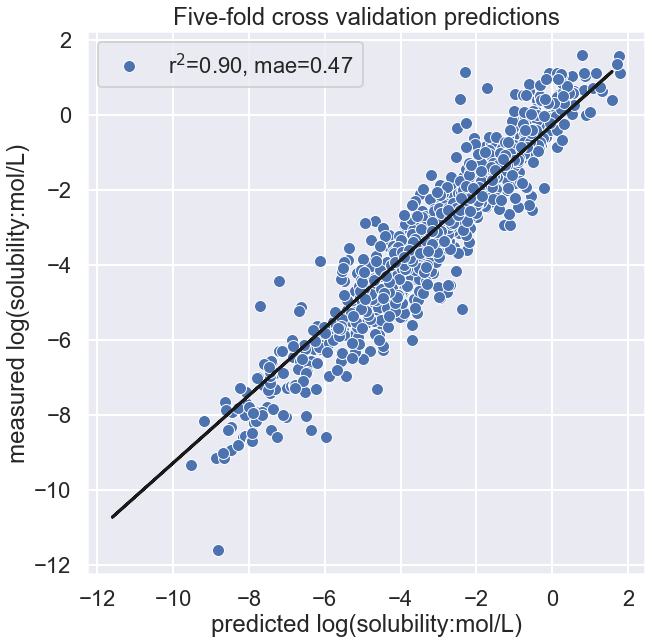

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

m, b = np.polyfit(preds_df['measured log(solubility:mol/L)'], preds_df['predicted log(solubility:mol/L)'], 1)

sns.set()
sns.set_context('poster')

ax = sns.scatterplot(x='predicted log(solubility:mol/L)', 
                     y='measured log(solubility:mol/L)', data=preds_df, label='r$^2$={:.2f}, mae={:.2f}'.format(r2, mae))

ax.plot(preds_df['measured log(solubility:mol/L)'], m*preds_df['measured log(solubility:mol/L)'] + b, c='k')


ax.set_title('Five-fold cross validation predictions')
plt.savefig('data/five-fold.png')

In [20]:
import time
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn import clone
import numpy as np

N_FOLDS = 3

for name, ml_model in models.items():
    print("Training on", name)
    t0 = time.time()
    # Shuffle the indices for the k-fold cross-validation
    kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=0)

    # Results for each of the cross-validation folds
    r2_per_fold = []
    mae_per_fold = []

    # Loop over the folds
    for train_index, test_index in kf.split(X_train):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(ml_model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = X_train.iloc[train_index]
        train_y = y_train.iloc[train_index]

        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        test_x = X_train.iloc[test_index]
        test_y = y_train.iloc[test_index]
        
        predicted_y = fold_model.predict(test_x)

        
        r2 = r2_score(test_y, predicted_y)
        mae = mean_absolute_error(test_y, predicted_y)

        r2_per_fold.append(r2)
        mae_per_fold.append(mae)

    # Print statistics of results
    print(
        f"Mean r2: {np.mean(r2_per_fold):.2f} \t"
        f"and std : {np.std(r2_per_fold):.2f} \n"
        f"Mean mae: {np.mean(mae_per_fold):.2f} \t"
        f"and std : {np.std(mae_per_fold):.2f} \n"
        f"Time taken : {time.time() - t0:.2f}s\n"
    )


Training on rf
Mean r2: 0.23 	and std : 0.33 
Mean mae: 0.74 	and std : 0.25 
Time taken : 0.58s

Training on svm
Mean r2: -0.14 	and std : 0.13 
Mean mae: 0.95 	and std : 0.19 
Time taken : 0.03s

Training on ann


/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Mean r2: -0.15 	and std : 0.53 
Mean mae: 0.95 	and std : 0.29 
Time taken : 0.39s

Training on knn
Mean r2: -0.58 	and std : 0.21 
Mean mae: 1.10 	and std : 0.04 
Time taken : 0.04s



/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/opt/anaconda3/envs/intro-chem/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:1870: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


In [27]:
df = pd.read_csv('data/solubility.txt', sep='\t')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/solubility.txt'